# Import libraries

In [1]:
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import pandas as pd
import numpy as np
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from scipy.sparse import issparse
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score



# Load dataset

In [ ]:
dataset_pca = pd.read_json('data/dataset.json')

dataset_pca

,timestamp,text,text_id,user,user_id
0,2024-10-31 00:00:00,Running a business means juggling countless ad...,2018569761,danielwoodard,1077866112
1,2024-10-31 00:00:00,Liz Truss is walking in the lingering shadow o...,2092717718,nelsonjacqueline,1089670430
2,2024-10-31 00:00:00,The UK is bracing for war as government buildi...,2059143248,ihooper,1007478642
3,2024-10-31 00:00:00,Marrying a second or third cousin once removed...,2008209828,wrightnicholas,1039258480
4,2024-10-31 00:00:00,It's truly disgraceful how the Indian National...,2001239278,michael51,1021455936
...,...,...,...,...,...
70255,2024-10-31 23:59:52,"@bakerjulie: ""Saranghae, I’m your resident K-P...",2086649509,valdezjennifer,1094330726
70256,2024-10-31 23:59:52,Soaring to new heights with @sweeneyanthony! T...,2039889186,nashshaun,1015245531
70257,2024-10-31 23:59:54,"Hey @james20 @paul47, did you see the latest f...",2020468196,brownregina,1029384492
70258,2024-10-31 23:59:58,Check out the fundraiser exhibition by @joanna...,2037744299,dkey,1046050046


# SVD for dimensionality Reduction

## Preprocessing the data

PCA requires a numerical data representation to be able to calculate Eigenvectors etc. during its process:



Possible Approach:

- timestamp: Can be converted to a numerical format (e.g., Unix timestamp or days from a reference date).
- text: Cannot directly be used; instead, we can use text embedding techniques like *TF-IDF* or sentence embeddings to represent this as numerical data.
- text_id, user, user_id: Unique identifiers; user_id and text_id may be relevant for joining or relational purposes but not for PCA directly.

### Convert Timestamp to integer-format

In [5]:
# Convert timestamp to numerical format

# get the earliest timestamp
earliest_timestamp = dataset_pca['timestamp'].min()

# use the earliest timestamp as the base, and convert the timestamp to seconds
dataset_pca['timestamp'] = (dataset_pca['timestamp'] - earliest_timestamp).dt.total_seconds()

dataset_pca['timestamp']

0            0.0
1            0.0
2            0.0
3            0.0
4            0.0
          ...   
70255    86392.0
70256    86392.0
70257    86394.0
70258    86398.0
70259    86399.0
Name: timestamp, Length: 70260, dtype: float64

### Preprocessing of `text`.

### Transforming Text Data into Numerical Features
   - The `text` field in the dataset is converted into numerical features using the **TF-IDF (Term Frequency-Inverse Document Frequency)** method.
   - **Reasoning**: TF-IDF captures the importance of words in each document relative to the entire corpus, emphasizing unique and meaningful terms while down-weighting commonly occurring ones (e.g., stopwords).

In [8]:

tfidf_vectorizer_raw = TfidfVectorizer(max_features=500)
text_features_raw = tfidf_vectorizer_raw.fit_transform(dataset_pca['text'])
feature_names_raw = tfidf_vectorizer_raw.get_feature_names_out()

# Compute average scores again
tfidf_matrix_raw = text_features_raw.toarray()
average_tfidf_scores_raw = np.mean(tfidf_matrix_raw, axis=0)
sorted_features_raw = sorted(zip(feature_names_raw, average_tfidf_scores_raw), key=lambda x: x[1], reverse=True)

print("Top 50 TF-IDF Features Before Preprocessing:")
for term, score in sorted_features_raw[:50]:
    print(f"{term}: {score:.4f}")

Top 50 TF-IDF Features Before Preprocessing:
the: 0.0983
to: 0.0710
and: 0.0681
for: 0.0637
co: 0.0563
https: 0.0560
of: 0.0507
in: 0.0495
it: 0.0432
is: 0.0429
your: 0.0377
on: 0.0367
with: 0.0358
business: 0.0356
health: 0.0332
you: 0.0281
out: 0.0273
this: 0.0271
our: 0.0268
at: 0.0251
can: 0.0250
let: 0.0238
yhawkins: 0.0228
are: 0.0214
we: 0.0214
check: 0.0203
from: 0.0198
politics: 0.0193
just: 0.0192
that: 0.0190
all: 0.0186
time: 0.0178
about: 0.0176
as: 0.0176
more: 0.0176
my: 0.0174
be: 0.0174
vote: 0.0163
not: 0.0156
their: 0.0156
science: 0.0156
by: 0.0154
support: 0.0148
new: 0.0146
don: 0.0146
like: 0.0146
but: 0.0137
make: 0.0136
up: 0.0135
here: 0.0132


The above are the top 50 words ranked by importance. We can see many stopwords like `the`, `to`, `and`, `for`, `of`, `in`, `is`. They are high-frequency, low-information terms and need irrelevant for the analysis.

Words like `co` and `https` suggest that URLs or special tokens are present in the text. We remove these aswell.

### Cleaning the `text` field of irrelevant data
   - Remove stopwords from the `text`-field, store the result in a new column **text_preprocessed** 

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
import numpy as np

# Preprocessing: Remove unwanted patterns from text
dataset_pca['text_preprocessed'] = dataset_pca['text'].str.replace(r'https?://\S+|www\.\S+', '', regex=True)  # Remove URLs
dataset_pca['text_preprocessed'] = dataset_pca['text_preprocessed'].str.replace(r'\bhttps\b', '', regex=True)  # Remove standalone 'https'
dataset_pca['text_preprocessed'] = dataset_pca['text_preprocessed'].str.replace(r'\b\d+\b', '', regex=True)  # Remove standalone numbers

# Define additional words to remove
custom_stop_words = {'just', 'let', 'make', 'hey'}

# Combine custom stop words with English stop words
all_stop_words = list(ENGLISH_STOP_WORDS.union(custom_stop_words))  # Convert to list

# Initialize TfidfVectorizer with the combined stop words
# TODO: Stemming and lemmatization can be added here
tfidf_vectorizer = TfidfVectorizer(max_features=500, stop_words=all_stop_words)

# Fit and transform the text data
text_features = tfidf_vectorizer.fit_transform(dataset_pca['text_preprocessed'])
feature_names = tfidf_vectorizer.get_feature_names_out()

# Compute average TF-IDF scores
tfidf_matrix = text_features.toarray()
average_tfidf_scores = np.mean(tfidf_matrix, axis=0)
sorted_features = sorted(zip(feature_names, average_tfidf_scores), key=lambda x: x[1], reverse=True)

# Display the top 50 features
print("Top 50 TF-IDF Features After Preprocessing:")
for term, score in sorted_features[:50]:
    print(f"{term}: {score:.4f}")

# Validate that unwanted words are removed
print(f"Unwanted words still in vocabulary: {custom_stop_words.intersection(set(feature_names))}")


Top 50 TF-IDF Features After Preprocessing:
business: 0.0448
health: 0.0414
yhawkins: 0.0273
politics: 0.0260
check: 0.0254
time: 0.0229
vote: 0.0199
like: 0.0198
science: 0.0196
don: 0.0184
support: 0.0183
new: 0.0178
climate: 0.0159
love: 0.0146
social: 0.0141
need: 0.0136
world: 0.0130
artist: 0.0124
voting: 0.0122
btsbbmas: 0.0121
people: 0.0119
mental: 0.0117
join: 0.0115
healthcare: 0.0115
latest: 0.0113
best: 0.0112
ready: 0.0107
high: 0.0101
rt: 0.0101
bbmas: 0.0100
army: 0.0098
change: 0.0098
crucial: 0.0097
real: 0.0096
help: 0.0093
wait: 0.0093
stay: 0.0093
looking: 0.0093
energy: 0.0092
low: 0.0092
impact: 0.0091
bts: 0.0090
miss: 0.0090
work: 0.0090
care: 0.0086
important: 0.0084
believe: 0.0084
power: 0.0082
learn: 0.0082
news: 0.0079
Unwanted words still in vocabulary: set()


The preprocessing ensures that irrelevant patterns (e.g., URLs, standalone numbers) are eliminated, and key terms are extracted. The top terms indicate the most relevant topics discussed in the dataset

# Check for Correlations

This code snippet is designed to analyze the correlation between the top 50 impactful features in the dataset after TF-IDF transformation. Dimensionality reduction requires the data to be correlated.

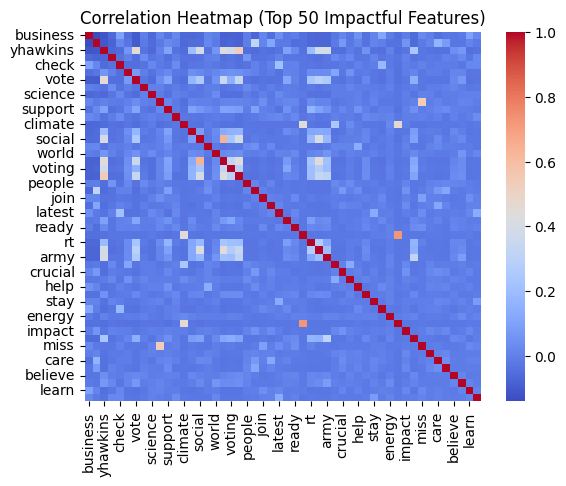

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
"""
# Convert the TF-IDF matrix to a dense DataFrame for easier manipulation
tfidf_df = pd.DataFrame(text_features.toarray(), columns=feature_names)

# Compute the correlation matrix
correlation_matrix = tfidf_df.corr()

# Display the correlation matrix
print("Correlation Matrix (Sample):")
print(correlation_matrix.head())
"""

# Sort features by average TF-IDF scores
sorted_feature_indices = np.argsort(average_tfidf_scores)[::-1]  # Indices sorted by descending importance
top_feature_indices = sorted_feature_indices[:50]  # Select top 20 features
top_features = [feature_names[i] for i in top_feature_indices]

# Create heatmap with top features
sns.heatmap(
    correlation_matrix.loc[top_features, top_features], 
    annot=False, cmap="coolwarm"
)

plt.title("Correlation Heatmap (Top 50 Impactful Features)")
plt.show()


The heatmap illustrates the pairwise correlations among the top 50 impactful features identified from TF-IDF analysis. Most features are relatively independent, as indicated by the weak off-diagonal correlations. However, some feature pairs exhibit stronger correlations, suggesting potential thematic overlaps in the text data. This analysis supports the need for dimensionality reduction to effectively capture these relationships in a compact representation.

# Analyzing the Impact of Feature Count on Variance in TF-IDF Matrix

**Limiting the Vocabulary (`max_features=500`)**
   - To manage the high dimensionality of textual data, only the **top 500 most relevant terms** are retained.
   - **Justification**: 
     - This decision balances computational efficiency with information retention.
     - The cumulative explained variance plot for different `max_features` values showed that 500 features provide a good trade-off.


If max_features=500, only the 500 most frequent and impactful terms will be retained, while the rest are discarded.

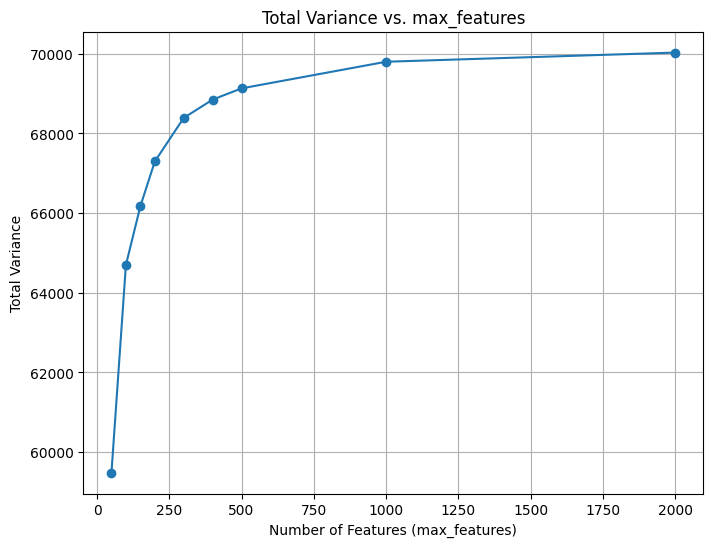

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

feature_sizes = [50, 100, 150, 200, 300, 400, 500, 1000, 2000]
explained_variances = []

for max_features in feature_sizes:
    tfidf_vectorizer = TfidfVectorizer(max_features=max_features, stop_words=all_stop_words)
    text_features = tfidf_vectorizer.fit_transform(dataset_pca['text_preprocessed'])
    
    # Calculate total variance in the TF-IDF matrix
    total_variance = text_features.power(2).sum()
    explained_variances.append(total_variance)

plt.figure(figsize=(8, 6))
plt.plot(feature_sizes, explained_variances, marker='o')
plt.title('Total Variance vs. max_features')
plt.xlabel('Number of Features (max_features)')
plt.ylabel('Total Variance')
plt.grid(True)
plt.show()


The plot illustrates the relationship between the number of features (max_features) in the TF-IDF vectorizer and the total variance in the resulting matrix. As the number of features increases, the total variance grows, reflecting that more terms capture additional information from the dataset. However, the increase may plateau at higher feature counts, indicating diminishing returns from including less impactful terms.


**max_features=500 is a good choice because it captures a large portion of the variance** -> Only the 500 most frequent and impactful terms will be retained, while the rest are discarded.

# Evaluating the Impact of Number of Components on Explained Variance



**Use TruncatedSVD instead of PCA to handle sparsity**
   - Since TF-IDF produces a sparse matrix, **TruncatedSVD** is used to reduce dimensionality while retaining as much variance as possible.
   - TruncatedSVD handles sparse matrices efficiently without requiring dense conversion.

TF-IDF Produces a sparse matrix! This is why we apply SVD instead of PCA.

In [ ]:
issparse(text_features)

True


To optimize the number of components (`n_components`), the **cumulative explained variance** was analyzed for different values. This helps determine how much information is retained as the dimensionality is reduced.

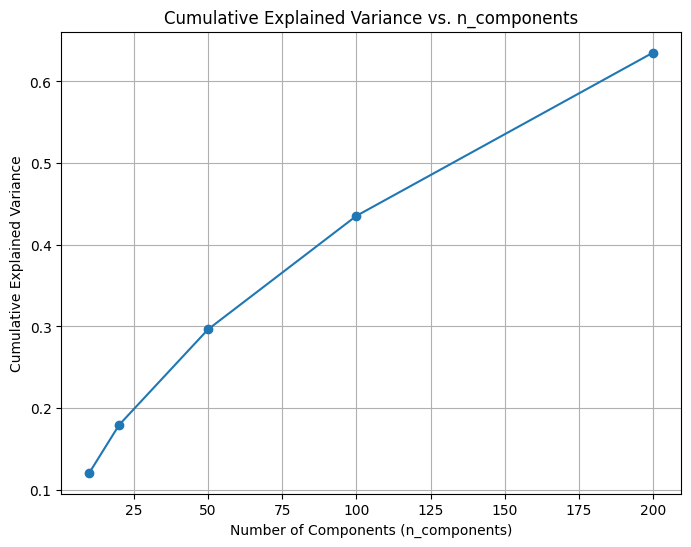

In [23]:

# Test different values for n_components
n_components_list = [10, 20, 50, 100, 200]
cumulative_variances = []

for n_components in n_components_list:
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    svd.fit(text_features)
    cumulative_variances.append(svd.explained_variance_ratio_.sum())

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(n_components_list, cumulative_variances, marker='o')
plt.title('Cumulative Explained Variance vs. n_components')
plt.xlabel('Number of Components (n_components)')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

his plot visualizes the relationship between the number of principal components (n_components) used in Truncated Singular Value Decomposition (SVD) and the cumulative explained variance.

There's no clear elbow point in this plot: The variance is distributed across many components without a sharp plateau. This is common in text data represented by TF-IDF.

Evaluating performance metrics (e.g., clustering silhouette scores or topic coherence) for different numbers of components is critical to determine the optimal balance between dimensionality reduction and information retention.

Every SVD Component summarizes multiple of the original words. Here's an example:


In [ ]:
### STEPS SO FAR ###

# Step 1: Vectorize the preprocessed text using TF-IDF
# Use fixed max_features=500 to limit the number of terms
tfidf_vectorizer = TfidfVectorizer(max_features=500, stop_words=all_stop_words)
text_features = tfidf_vectorizer.fit_transform(dataset_pca['text_preprocessed'])

# Extract the feature names (words corresponding to columns in the TF-IDF matrix)
feature_names = tfidf_vectorizer.get_feature_names_out()

# Step 2: Reduce dimensionality using TruncatedSVD
# Define the number of components for dimensionality reduction
final_n_components = 50  # We will test different values later

# Apply TruncatedSVD to reduce the dimensionality of the TF-IDF matrix
svd = TruncatedSVD(n_components=final_n_components, random_state=42)
svd_features = svd.fit_transform(text_features)

# Step 3: Analyze SVD components
# Each SVD component represents a latent concept; we analyze the top words contributing to each component
components = svd.components_  # Shape: (n_components, n_features)

# Define the number of top words to display for each component
top_n_words = 10

# Display the top contributing words for each SVD component
print(f"Top {top_n_words} words contributing to each of the {final_n_components} SVD components:\n")

for i, component in enumerate(components):
    # Sort the features (words) by their importance (absolute weight) in the component
    top_indices = component.argsort()[::-1][:top_n_words]  # Indices of top N words
    top_words = [feature_names[j] for j in top_indices]    # Get the corresponding words
    top_weights = component[top_indices]                  # Get the weights for these words

    # Print the component number and the top words with their weights
    print(f"Component {i + 1}:")
    for word, weight in zip(top_words, top_weights):
        print(f"  {word}: {weight:.4f}")
    print("\n")


Top 10 words contributing to each of the 8 SVD components:

Component 1:
  yhawkins: 0.4544
  vote: 0.3072
  business: 0.2219
  artist: 0.2101
  btsbbmas: 0.2091
  social: 0.2082
  health: 0.1923
  voting: 0.1760
  bbmas: 0.1673
  support: 0.1639


Component 2:
  business: 0.4838
  health: 0.3824
  check: 0.2114
  politics: 0.1558
  new: 0.1092
  mental: 0.1064
  like: 0.1012
  climate: 0.0981
  science: 0.0963
  latest: 0.0819


Component 3:
  climate: 0.4549
  oct: 0.3908
  precip: 0.3890
  snow: 0.3890
  low: 0.3849
  high: 0.3821
  missing: 0.0610
  change: 0.0375
  yhawkins: 0.0286
  crisis: 0.0216


Component 4:
  health: 0.6656
  mental: 0.1987
  healthcare: 0.0929
  care: 0.0924
  prioritize: 0.0686
  mentalhealth: 0.0655
  mentalhealthawareness: 0.0651
  wellness: 0.0636
  secretary: 0.0612
  important: 0.0589


Component 5:
  politics: 0.8961
  like: 0.1349
  political: 0.1154
  time: 0.0865
  people: 0.0864
  science: 0.0648
  change: 0.0532
  focus: 0.0478
  real: 0.0461
  

The SVD components are sorted based on the variance they explain in the original data. First Component explains the most variance, while the last Component explains the least.

# Evaluating Clustering Performance Across Dimensions and Cluster Sizes

## Overview:
 The silhouette score is used to assess the quality of clusters. A higher silhouette score indicates better-defined and more cohesive clusters. This experiment tests how the number of SVD components (`n_components`) and the number of clusters (`n_clusters`) affect clustering performance.

## First Experiment:
- Apply dimensionality reduction with TruncatedSVD for `n_components` values of 50, 100, and 200.
- Normalize the resulting reduced features for better clustering.
- Evaluate clustering quality using KMeans across a range of cluster sizes (2 to 10 clusters).
- Visualize the results to identify the optimal configuration.

In [14]:
# Function to evaluate clustering for a given n_components
def evaluate_clustering(text_features, n_components, n_clusters_range):
    results = []
    
    # Apply TruncatedSVD
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    svd_features = svd.fit_transform(text_features)
    
    # Normalize the features
    scaler = StandardScaler()
    svd_features_normalized = scaler.fit_transform(svd_features)
    
    # Evaluate clustering for different n_clusters
    for n_clusters in n_clusters_range:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        clusters = kmeans.fit_predict(svd_features_normalized)
        silhouette = silhouette_score(svd_features_normalized, clusters)
        results.append((n_components, n_clusters, silhouette))
    
    return results

Execute the Pipeline for Multiple n_components

In [ ]:
# Caution: This takes a long time to run!

# Define ranges for n_components and n_clusters
n_components_list = [50, 100, 200]
n_clusters_range = range(2, 11)  # Test between 2 and 10 clusters

# Store all results
all_results = []

for n_components in n_components_list:
    results = evaluate_clustering(text_features, n_components, n_clusters_range)
    all_results.extend(results)

# Convert results to a DataFrame for comparison
results_df = pd.DataFrame(all_results, columns=['n_components', 'n_clusters', 'silhouette_score'])

# Display results
print(results_df)


KeyboardInterrupt: 

 Plot Silhouette Scores

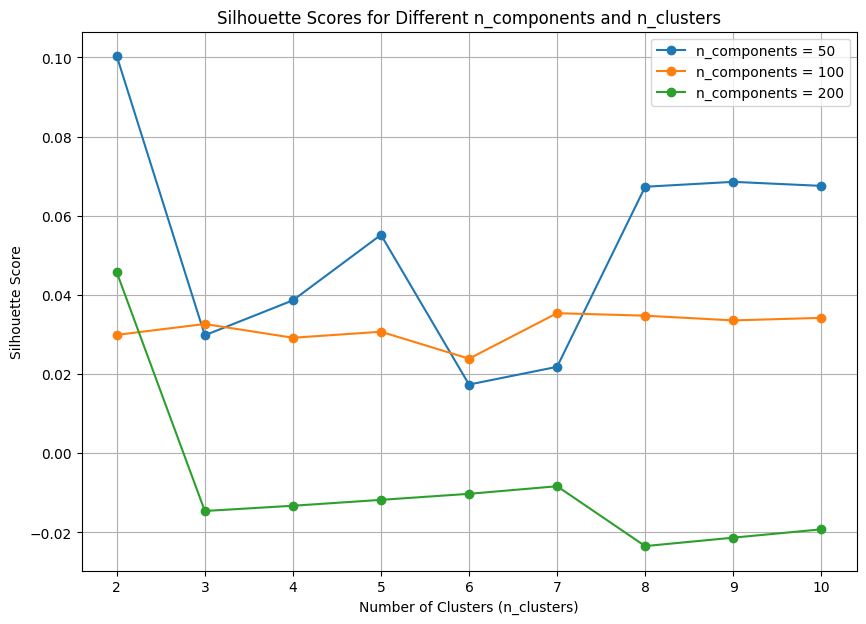

In [22]:
# Plot silhouette scores for each n_components
plt.figure(figsize=(10, 7))

for n_components in n_components_list:
    subset = results_df[results_df['n_components'] == n_components]
    plt.plot(subset['n_clusters'], subset['silhouette_score'], marker='o', label=f'n_components = {n_components}')

plt.title('Silhouette Scores for Different n_components and n_clusters')
plt.xlabel('Number of Clusters (n_clusters)')
plt.ylabel('Silhouette Score')
plt.legend()
plt.grid(True)
plt.show()


### Result of first Experiment:

- Lower dimensions (e.g., n_components = 50) are generally more effective for clustering this dataset, as they retain meaningful variance while removing noise. The next analysis will focus on lower dimensions.

- Two cluster and 8-10 clusters (n_clusters = 8-10) often lead to better silhouette scores, especially for lower-dimensional data, suggesting a higher-resolution grouping of the dataset is meaningful. This also will be adressed further


Best results: 
- 50 n_components
- 2 or 8-10 Clusters

## Second Experiment:
- Extend the dimensionality reduction range to include `n_components` values of 10, 20, 50, and 100 to test how lower dimensions compare to the previously tested higher dimensions.
- Normalize the reduced SVD features to improve clustering performance.
- Use **MiniBatchKMeans** to accelerate clustering evaluation for a range of cluster sizes (2 to 10 clusters).
- Measure clustering performance using the **silhouette score**, which captures the cohesiveness and separation of clusters.
- Visualize the results to determine which combination of `n_components` and `n_clusters` provides the most optimal clustering.


In [31]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def analyze_clusters_with_components(text_features, n_components_list, n_clusters_range, feature_names):
    """
    Analyzes clustering performance across different n_components and n_clusters.
    
    Parameters:
    - text_features: Sparse matrix of TF-IDF features.
    - n_components_list: List of n_components values to test for dimensionality reduction.
    - n_clusters_range: Range of cluster numbers to evaluate (e.g., range(3, 8)).
    - feature_names: List of feature names from TF-IDF.

    Returns:
    - results_df: DataFrame with silhouette scores for all tested (n_components, n_clusters).
    - best_configuration: Dictionary with the best n_components, n_clusters, silhouette_score, and clusters.
    """
    evaluation_results = []
    best_silhouette_score = -1
    best_configuration = {}

    for n_components in n_components_list:
        # Step 1: Reduce dimensionality using TruncatedSVD
        svd = TruncatedSVD(n_components=n_components, random_state=42)
        svd_features = svd.fit_transform(text_features)

        # Normalize the SVD features
        scaler = StandardScaler()
        svd_features_normalized = scaler.fit_transform(svd_features)

        # Step 2: Evaluate clustering for different n_clusters
        for n_clusters in n_clusters_range:
            # Use MiniBatchKMeans for faster clustering
            kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42, batch_size=1000)
            clusters = kmeans.fit_predict(svd_features_normalized)

            # Evaluate clustering with silhouette score
            silhouette = silhouette_score(svd_features_normalized, clusters, n_jobs=-1)
            evaluation_results.append({
                'n_components': n_components,
                'n_clusters': n_clusters,
                'silhouette_score': silhouette
            })

            # Track the best clustering configuration
            if silhouette > best_silhouette_score:
                best_silhouette_score = silhouette
                best_configuration = {
                    'n_components': n_components,
                    'n_clusters': n_clusters,
                    'silhouette_score': silhouette,
                    'clusters': clusters,
                    'svd': svd,
                    'kmeans': kmeans
                }

            print(f"n_components={n_components}, n_clusters={n_clusters}, Silhouette Score={silhouette:.4f}")

    # Convert results to a DataFrame for easier visualization
    results_df = pd.DataFrame(evaluation_results)

    return results_df, best_configuration


n_components=10, n_clusters=2, Silhouette Score=0.3382
n_components=10, n_clusters=3, Silhouette Score=0.2138
n_components=10, n_clusters=4, Silhouette Score=0.2753
n_components=10, n_clusters=5, Silhouette Score=0.1819
n_components=10, n_clusters=6, Silhouette Score=0.2630
n_components=10, n_clusters=7, Silhouette Score=0.2876
n_components=10, n_clusters=8, Silhouette Score=0.3585
n_components=10, n_clusters=9, Silhouette Score=0.3836
n_components=10, n_clusters=10, Silhouette Score=0.4191
n_components=20, n_clusters=2, Silhouette Score=0.0489
n_components=20, n_clusters=3, Silhouette Score=0.0671
n_components=20, n_clusters=4, Silhouette Score=0.0822
n_components=20, n_clusters=5, Silhouette Score=0.0952
n_components=20, n_clusters=6, Silhouette Score=0.1118
n_components=20, n_clusters=7, Silhouette Score=0.1395
n_components=20, n_clusters=8, Silhouette Score=0.2012
n_components=20, n_clusters=9, Silhouette Score=0.2047
n_components=20, n_clusters=10, Silhouette Score=0.1536
n_compon

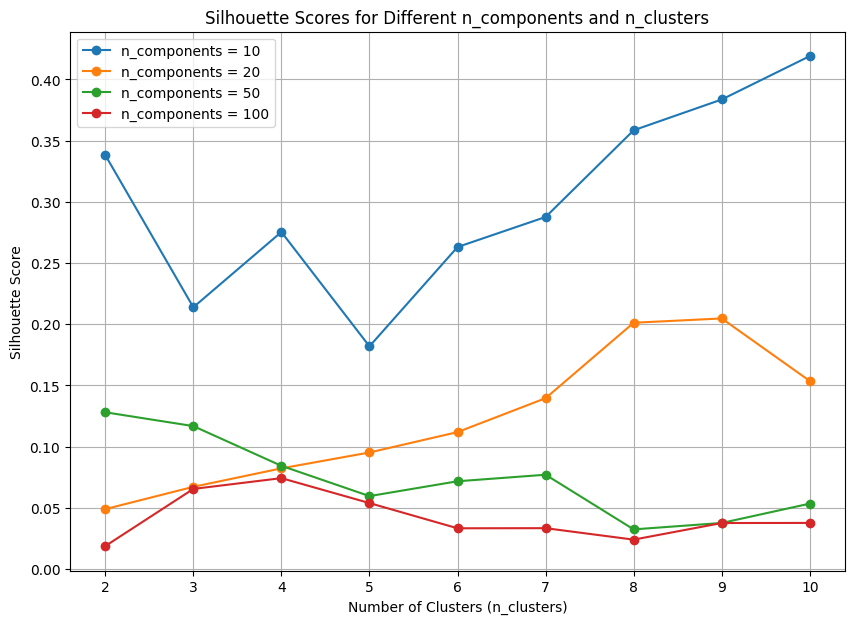


Best Configuration:
n_components: 10
n_clusters: 10
Silhouette Score: 0.4191


In [36]:
# CAUTION: This step may take a long time to run!

# Step 1: Vectorize the preprocessed text using TF-IDF
# Use fixed max_features=500 to limit the number of terms
tfidf_vectorizer = TfidfVectorizer(max_features=500, stop_words=all_stop_words)
text_features = tfidf_vectorizer.fit_transform(dataset_pca['text_preprocessed'])

# Extract the feature names (words corresponding to columns in the TF-IDF matrix)
feature_names = tfidf_vectorizer.get_feature_names_out()

# Define the ranges for n_components and n_clusters
n_components_list = [10, 20, 50, 100]  # Adjust based on dataset size and explained variance
n_clusters_range = range(2, 11)

# Analyze clustering performance for different configurations
results_df, best_configuration = analyze_clusters_with_components(
    text_features=text_features,
    n_components_list=n_components_list,
    n_clusters_range=n_clusters_range,
    feature_names=feature_names
)

# Step 3: Plot silhouette scores for each n_components
plt.figure(figsize=(10, 7))

for n_components in n_components_list:
    subset = results_df[results_df['n_components'] == n_components]
    plt.plot(subset['n_clusters'], subset['silhouette_score'], marker='o', label=f'n_components = {n_components}')

plt.title('Silhouette Scores for Different n_components and n_clusters')
plt.xlabel('Number of Clusters (n_clusters)')
plt.ylabel('Silhouette Score')
plt.legend()
plt.grid(True)
plt.show()

# Step 4: Display the best configuration
print("\nBest Configuration:")
print(f"n_components: {best_configuration['n_components']}")
print(f"n_clusters: {best_configuration['n_clusters']}")
print(f"Silhouette Score: {best_configuration['silhouette_score']:.4f}")



### Result of Second Experimentation:
- Lower dimensions (e.g., `n_components = 10`) consistently show stronger clustering performance for small numbers of clusters. This indicates that fewer dimensions effectively capture the structure of the dataset.
- Higher dimensions (e.g., `n_components = 100`) tend to show lower silhouette scores, likely due to the inclusion of noise or less meaningful variance in the data.
- Two distinct patterns emerge:
  - **n_clusters = 2**: This configuration achieves strong silhouette scores, indicating that the dataset may have a coarse, high-level grouping.
  - **n_clusters = 8-10**: These clusters provide higher-resolution subgroupings, especially for lower-dimensional data.

### Best Configuration:
- **n_components:** 10
- **n_clusters:** 10
- **Silhouette Score:** ~0.42



## Third Experiment:
- Narrow the dimensionality reduction range to `n_components` values of 8, 9, 11, and 12, targeting the dimensions where meaningful clustering starts to emerge based on previous experiments.
- Continue normalizing the SVD features to enhance clustering stability and performance.
- Use **MiniBatchKMeans** to efficiently evaluate clustering over a refined range of cluster sizes (2 to 10 clusters).
- Compute the **silhouette score** for each configuration to determine clustering quality.
- Visualize the relationship between `n_components`, `n_clusters`, and silhouette scores to identify the optimal configuration for this dataset.


In [32]:
# CAUTION: Takes 120min to run!

# Step 1: Vectorize the preprocessed text using TF-IDF
# Use fixed max_features=500 to limit the number of terms
tfidf_vectorizer = TfidfVectorizer(max_features=500, stop_words=all_stop_words)
text_features = tfidf_vectorizer.fit_transform(dataset_pca['text_preprocessed'])

# Extract the feature names (words corresponding to columns in the TF-IDF matrix)
feature_names = tfidf_vectorizer.get_feature_names_out()

# Define the ranges for n_components and n_clusters
n_components_list = [8, 9, 11, 12]  # Adjust based on dataset size and explained variance
n_clusters_range = [2, 3, 4, 5, 6, 7, 8, 9, 10]

# Analyze clustering performance for different configurations
results_df, best_configuration = analyze_clusters_with_components(
    text_features=text_features,
    n_components_list=n_components_list,
    n_clusters_range=n_clusters_range,
    feature_names=feature_names
)




n_components=8, n_clusters=2, Silhouette Score=0.1525
n_components=8, n_clusters=3, Silhouette Score=0.2147
n_components=8, n_clusters=4, Silhouette Score=0.2621
n_components=8, n_clusters=5, Silhouette Score=0.3460
n_components=8, n_clusters=6, Silhouette Score=0.3732
n_components=8, n_clusters=7, Silhouette Score=0.4055
n_components=8, n_clusters=8, Silhouette Score=0.4395
n_components=8, n_clusters=9, Silhouette Score=0.4681
n_components=8, n_clusters=10, Silhouette Score=0.4348
n_components=9, n_clusters=2, Silhouette Score=0.3217
n_components=9, n_clusters=3, Silhouette Score=0.2153
n_components=9, n_clusters=4, Silhouette Score=0.2523
n_components=9, n_clusters=5, Silhouette Score=0.3095
n_components=9, n_clusters=6, Silhouette Score=0.3366
n_components=9, n_clusters=7, Silhouette Score=0.3743
n_components=9, n_clusters=8, Silhouette Score=0.4137
n_components=9, n_clusters=9, Silhouette Score=0.4438
n_components=9, n_clusters=10, Silhouette Score=0.4579
n_components=11, n_cluster

KeyError: 'inertia'

<Figure size 1000x700 with 0 Axes>

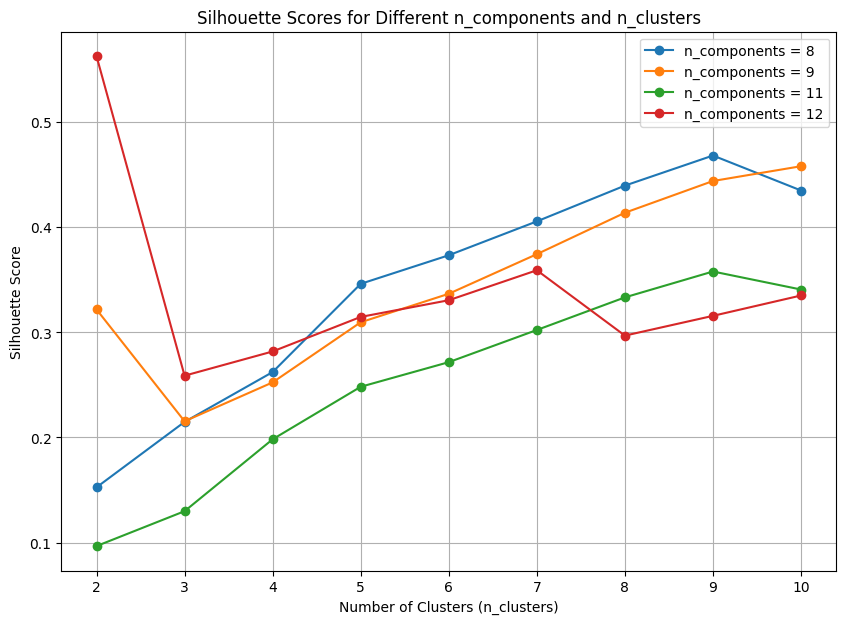


Best Configuration:
n_components: 12
n_clusters: 2
Silhouette Score: 0.5626


In [33]:

# Step 3: Plot silhouette scores for each n_components
plt.figure(figsize=(10, 7))

for n_components in n_components_list:
    subset = results_df[results_df['n_components'] == n_components]
    plt.plot(subset['n_clusters'], subset['silhouette_score'], marker='o', label=f'n_components = {n_components}')

plt.title('Silhouette Scores for Different n_components and n_clusters')
plt.xlabel('Number of Clusters (n_clusters)')
plt.ylabel('Silhouette Score')
plt.legend()
plt.grid(True)
plt.show()

# Step 4: Display the best configuration
print("\nBest Configuration:")
print(f"n_components: {best_configuration['n_components']}")
print(f"n_clusters: {best_configuration['n_clusters']}")
print(f"Silhouette Score: {best_configuration['silhouette_score']:.4f}")


### Result of Third Experimentation:

The results highlighted two key configurations:

- Finer-grained cluster distinctions with a moderate number of clusters and dimensions, achieving a reasonable trade-off between granularity and cluster quality.
- Coarse binary clustering, which revealed a strong high-level grouping in the dataset, suggesting that the data naturally segments into two overarching categories

### Best Configurations:

#### Finer-grained cluster Distinctions
- **n_components:** 8
- **n_clusters:** 9
- **Silhouette Score:** ~0.47

#### Coarse Binary Cluster Distinction
- **n_components:** 12
- **n_clusters:** 2
- **Silhouette Score:** ~0.56



# Final Clustering Analysis:
1. Use the **best configurations** to perform a detailed analysis of cluster characteristics, including dominant terms and user groupings.

## Approach:

1. **Text Vectorization using TF-IDF:**
   - Preprocessed the text data by removing URLs, standalone numbers, and irrelevant stop words.
   - Applied TF-IDF vectorization with a maximum of **500 features** to extract meaningful terms and their importance within the dataset.

2. **Dimensionality Reduction with TruncatedSVD:**
   - Reduced the dimensionality of the TF-IDF matrix using TruncatedSVD, retaining the most significant latent features while removing noise.
      - Analysis 1 uses `n_components=12`
      - Analysis 2 uses `n_components=8`
   - Normalized the resulting components using `StandardScaler` to standardize the data for clustering.

3. **Clustering with MiniBatchKMeans:**
   - Applied MiniBatchKMeans clustering for efficient grouping of the reduced feature set.
      - Analysis 1 with `n_clusters=2`
      - Analysis 1 with `n_clusters=9`
   - Transformed the cluster centers back to the original TF-IDF feature space to identify the top contributing terms for each cluster.

4. **Cluster Analysis:**
   - Extracted and ranked the top 10 terms contributing to each cluster to interpret their thematic focus.
   - Assigned clusters to each tweet and grouped users by their cluster assignments.
   - Evaluated user activity within each cluster by counting the number of tweets per user.


# Cluster approach: 2 Cluster, 12 n_components

Silhouette Score 0.5626

Top terms for each cluster:

Cluster 0:
  politics: 0.0098
  time: 0.0086
  don: 0.0072
  miss: 0.0037
  health: 0.0033
  check: 0.0026
  need: 0.0025
  change: 0.0023
  real: 0.0020
  like: 0.0020

Cluster 1:
  unknown: 3.7146
  climateemergency: 2.8569
  cop26: 2.8451
  times: 2.7851
  cop26glasgow: 2.7738
  seen: 2.7110
  alt: 2.6646
  scotradar: 2.6627
  united: 2.2549
  kingdom: 1.7799
Users in each cluster:

Cluster 0:
  Total users: 46754
  Example user IDs: [1078067202, 1090912262, 1032847366, 1033371660, 1039794189, 1041891346, 1005060115, 1060503572, 1009778710, 1020657687]

Cluster 1:
  Total users: 2
  Example user IDs: [1010626427, 1031499948]
User activity by cluster:

Cluster 0:


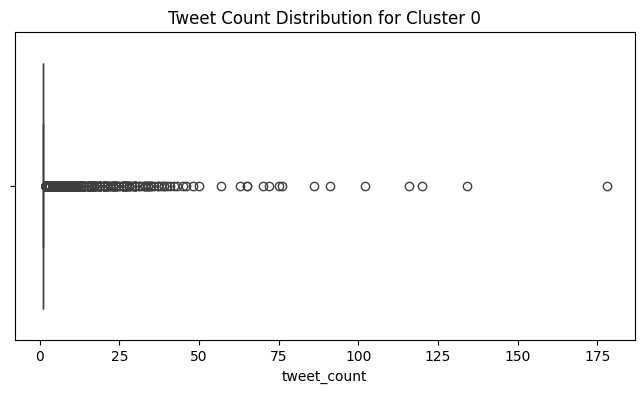

       cluster     user_id  tweet_count
36374        0  1077881120          178
3600         0  1007690223          134
14651        0  1031499948          120
25884        0  1055454345          116
22968        0  1049151527          102
38139        0  1081539622           91
31733        0  1068051022           86
10608        0  1022561255           76
3568         0  1007621559           75
30241        0  1064791428           72

Cluster 1:


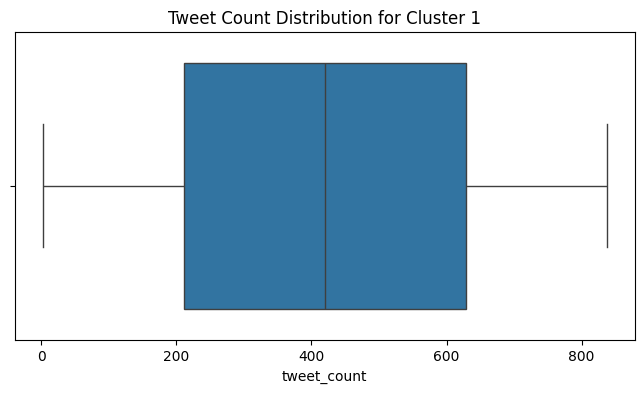

       cluster     user_id  tweet_count
46754        1  1010626427          837
46755        1  1031499948            3


In [56]:

# Step 1: Vectorize the preprocessed text using TF-IDF
# Use fixed max_features=500 to limit the number of terms
tfidf_vectorizer = TfidfVectorizer(max_features=500, stop_words=all_stop_words)
text_features = tfidf_vectorizer.fit_transform(dataset_pca['text_preprocessed'])

# Extract the feature names (words corresponding to columns in the TF-IDF matrix)
feature_names = tfidf_vectorizer.get_feature_names_out()

# Step 1: Reduce dimensionality using TruncatedSVD
svd = TruncatedSVD(n_components=12, random_state=42)
svd_features = svd.fit_transform(text_features)

# Normalize the SVD features
scaler = StandardScaler()
svd_features_normalized = scaler.fit_transform(svd_features)

# Use MiniBatchKMeans for faster clustering
kmeans = MiniBatchKMeans(n_clusters=2, random_state=42, batch_size=1000)
clusters = kmeans.fit_predict(svd_features_normalized)


###################

# Transform cluster centers back to the original TF-IDF feature space
original_space_centers = np.dot(kmeans.cluster_centers_, svd.components_)

# Top terms for each cluster
top_n_terms = 10  # Number of top terms to display per cluster
cluster_terms = {}

for cluster_idx, cluster_center in enumerate(original_space_centers):
    # Get indices of top terms for this cluster
    top_indices = cluster_center.argsort()[::-1][:top_n_terms]
    top_terms = [feature_names[i] for i in top_indices]
    top_weights = cluster_center[top_indices]
    
    # Store the terms and weights
    cluster_terms[cluster_idx] = list(zip(top_terms, top_weights))

# Display the top terms for each cluster
print("Top terms for each cluster:")
for cluster_idx, terms in cluster_terms.items():
    print(f"\nCluster {cluster_idx}:")
    for term, weight in terms:
        print(f"  {term}: {weight:.4f}")


##################


# Add cluster labels to the original dataset
dataset_pca['cluster'] = clusters  # 'clusters' is from kmeans.fit_predict()

# Group by clusters and extract user information
clustered_users = dataset_pca.groupby('cluster')['user_id'].apply(list)

# Display the user IDs in each cluster
print("Users in each cluster:")
for cluster_idx, users in clustered_users.items():
    print(f"\nCluster {cluster_idx}:")
    print(f"  Total users: {len(set(users))}")  # Unique users in the cluster
    print(f"  Example user IDs: {list(set(users))[:10]}")  # Show a sample of user IDs


########################

# Count tweets per user in each cluster
user_activity = dataset_pca.groupby(['cluster', 'user_id']).size().reset_index(name='tweet_count')

# Display user activity in each cluster
print("User activity by cluster:")
for cluster_idx in user_activity['cluster'].unique():
    print(f"\nCluster {cluster_idx}:")
    cluster_users = user_activity[user_activity['cluster'] == cluster_idx]
    # sort by tweet count
    cluster_users = cluster_users.sort_values(by='tweet_count', ascending=False)
    # Boxplot the distribution of tweet counts per user
    plt.figure(figsize=(8, 4))
    sns.boxplot(x='tweet_count', data=cluster_users)
    plt.title(f"Tweet Count Distribution for Cluster {cluster_idx}")
    plt.show()
    # Display top 10 users in this cluster
    print(cluster_users.head(10))  # Show top 10 rows for this cluster




### Results and Interpretation:

#### **Cluster Themes:**

1. **Cluster 0: General Discussions**
   - Dominated by terms such as "politics," "time," "support," and "mental," this cluster appears to represent broader, general discussions on various topics, including social support and political discourse.
   - The relatively low weights of the terms suggest diverse topics with less specific focus.

2. **Cluster 1: Climate Activism**
   - This cluster is highly specific and dominated by terms such as "climateemergency," "cop26," "cop26glasgow," and "united." It strongly indicates focused discussions on climate change and environmental activism.
   - The significantly higher term weights (e.g., "unknown" with 3.7211 and "climateemergency" with 2.8564) highlight the concentrated nature of this cluster.


#### **User Distribution and Activity:**

1. **Cluster 0:**
   - Comprises the majority of users (46,754), indicating a more general audience discussing a variety of topics.
   - Most users are low-frequency contributors, as seen from the majority of users having only 1 or 2 tweets.

**Cluster 0** represents the broader, general audience discussing multiple themes. Its large size and diversity imply that it encapsulates a wide range of opinions and topics, making it less focused but highly inclusive.


2. **Cluster 1:**
   - Consists of only **2 users**, highlighting the niche and exclusive focus of this cluster.
   - One user has contributed significantly more, with **837 tweets**, suggesting a dominant voice in this group.

**Cluster 1** is a highly specific niche group centered on climate change activism, as evidenced by the focused terms and limited user participation. The significant contribution from one dominant user (837 tweets) suggests that this cluster is driven by a few key influencers or activists.


# Cluster approach: 9 Cluster, 8 n_components
Silhouette Score: 0.4681

Top terms for each cluster:

Cluster 0:
  check: 1.6258
  latest: 0.5887
  business: 0.3388
  looking: 0.3356
  news: 0.1622
  science: 0.1580
  article: 0.1547
  stay: 0.1250
  new: 0.1236
  insights: 0.1215

Cluster 1:
  health: 1.7349
  mental: 0.5150
  healthcare: 0.2462
  care: 0.2413
  wellness: 0.1737
  prioritize: 0.1737
  mentalhealth: 0.1709
  mentalhealthawareness: 0.1676
  secretary: 0.1638
  important: 0.1524

Cluster 2:
  climate: 3.1965
  oct: 2.7792
  precip: 2.7666
  snow: 2.7665
  low: 2.7430
  high: 2.7165
  missing: 0.4315
  change: 0.2260
  crisis: 0.1468
  city: 0.1171

Cluster 3:
  like: 0.0890
  time: 0.0236
  science: 0.0187
  looks: 0.0178
  people: 0.0093
  feels: 0.0036
  change: 0.0036
  accountability: 0.0031
  planet: 0.0022
  truth: 0.0016

Cluster 4:
  yhawkins: 1.8984
  vote: 1.2477
  artist: 0.8850
  btsbbmas: 0.8788
  social: 0.8144
  bbmas: 0.7095
  voting: 0.7054
  army: 0.6125
  love: 0.5453
  rt: 0.5381

Cluster 5:
  politics: 3.3479
  political:

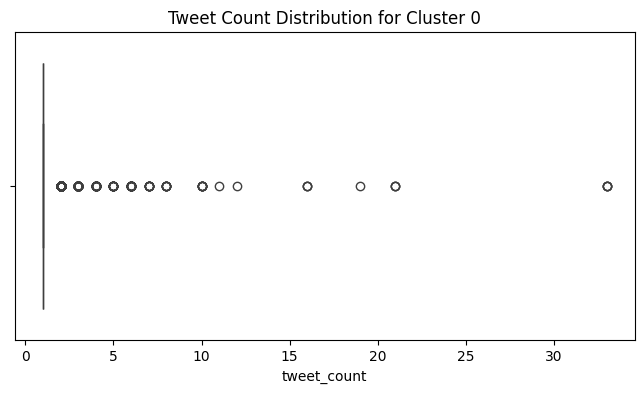

      cluster     user_id  tweet_count
3623        0  1096591518           33
1676        0  1042868374           33
210         0  1005181662           33
2238        0  1058511774           33
275         0  1006790726           21
2135        0  1055891373           21
3386        0  1090425947           21
2222        0  1057945446           19
34          0  1000842486           16
227         0  1005638455           16

Cluster 1:


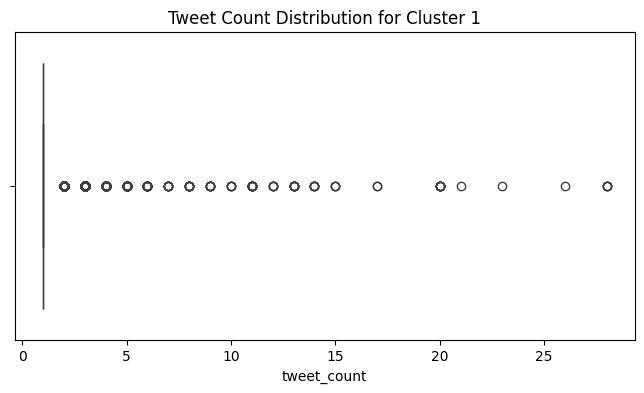

      cluster     user_id  tweet_count
9417        1  1078170052           28
7683        1  1054623093           28
8469        1  1064900086           28
4541        1  1011545400           28
6856        1  1043285277           26
7942        1  1058040076           23
5206        1  1021041031           21
5457        1  1024394316           20
4752        1  1014507367           20
5705        1  1027996901           20

Cluster 2:


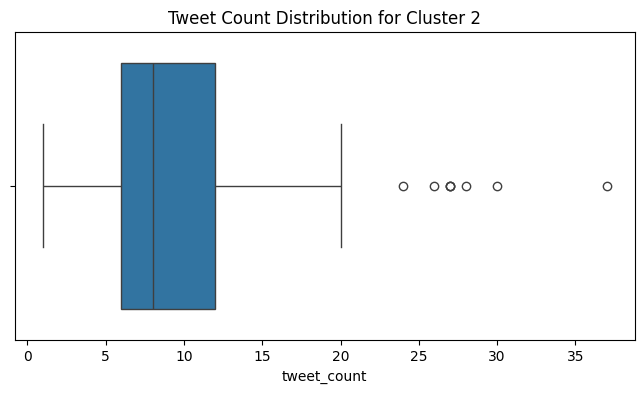

       cluster     user_id  tweet_count
11079        2  1049045932           37
11041        2  1020126593           30
11088        2  1052984539           28
11141        2  1097012010           27
11059        2  1037377223           27
11097        2  1063835038           27
11125        2  1079524421           26
11028        2  1009389692           24
11061        2  1038230812           20
11045        2  1024023012           20

Cluster 3:


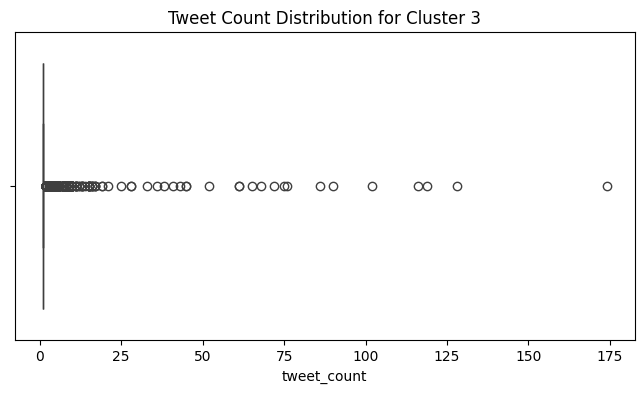

       cluster     user_id  tweet_count
28546        3  1077881120          174
12885        3  1007690223          128
18217        3  1031499948          119
23511        3  1055454345          116
22138        3  1049151527          102
29405        3  1081539622           90
26317        3  1068051022           86
16271        3  1022561255           76
12868        3  1007621559           75
25591        3  1064791428           72

Cluster 4:


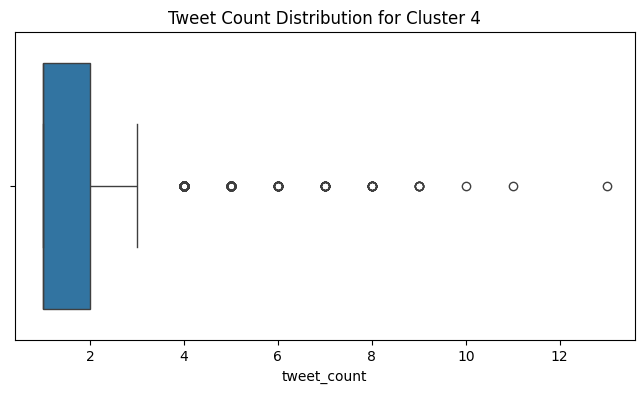

       cluster     user_id  tweet_count
36426        4  1066151354           13
35077        4  1036320312           11
35720        4  1050499846           10
33947        4  1009352259            9
36362        4  1064720821            9
35164        4  1038230812            9
37637        4  1093839895            9
34358        4  1019097334            9
35725        4  1050607585            8
35186        4  1038802933            8

Cluster 5:


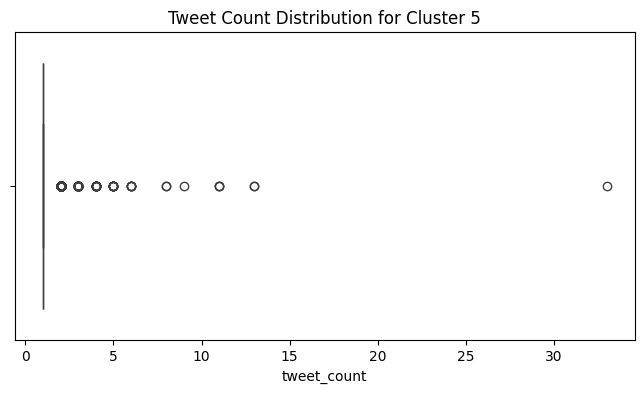

       cluster     user_id  tweet_count
41134        5  1091107439           33
39750        5  1051170695           13
39925        5  1055990672           13
39048        5  1032787556           11
41252        5  1094046784           11
37936        5  1001623075           11
38569        5  1019342937            9
38857        5  1028070917            8
40676        5  1077335926            8
39929        5  1056051961            6

Cluster 6:


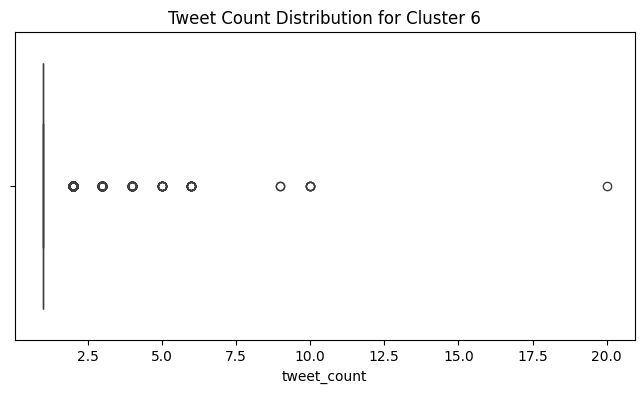

       cluster     user_id  tweet_count
43110        6  1064632123           20
42639        6  1046429310           10
43611        6  1084367800           10
41763        6  1011255402           10
42166        6  1029185527           10
41615        6  1005692748            9
41498        6  1000590761            9
42896        6  1057132469            6
43136        6  1065577765            6
41566        6  1003790730            6

Cluster 7:


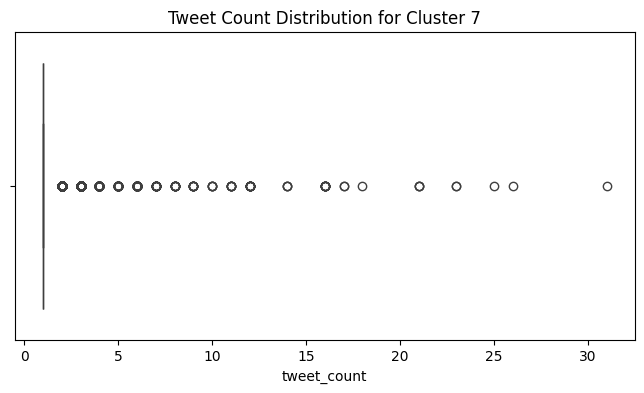

       cluster     user_id  tweet_count
50169        7  1088437710           31
49026        7  1072645177           26
44980        7  1013703855           25
46092        7  1029822087           23
50520        7  1093226962           23
50372        7  1091258438           21
50584        7  1094055635           21
48699        7  1068317723           21
45129        7  1015510985           18
49160        7  1074306919           17

Cluster 8:


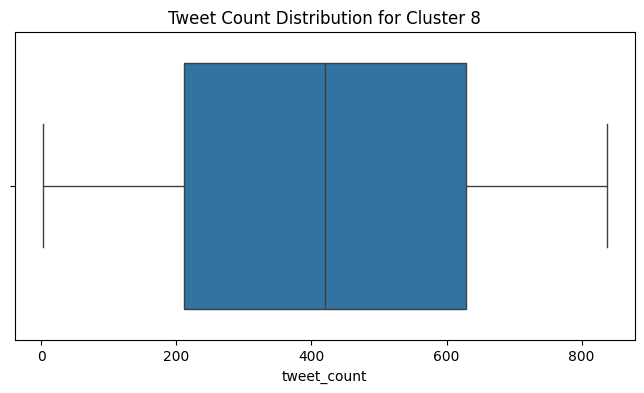

       cluster     user_id  tweet_count
51000        8  1010626427          837
51001        8  1031499948            3


In [57]:

# Step 1: Vectorize the preprocessed text using TF-IDF
# Use fixed max_features=500 to limit the number of terms
tfidf_vectorizer = TfidfVectorizer(max_features=500, stop_words=all_stop_words)
text_features = tfidf_vectorizer.fit_transform(dataset_pca['text_preprocessed'])

# Extract the feature names (words corresponding to columns in the TF-IDF matrix)
feature_names = tfidf_vectorizer.get_feature_names_out()

# Step 1: Reduce dimensionality using TruncatedSVD
svd = TruncatedSVD(n_components=8, random_state=42)
svd_features = svd.fit_transform(text_features)

# Normalize the SVD features
scaler = StandardScaler()
svd_features_normalized = scaler.fit_transform(svd_features)

# Use MiniBatchKMeans for faster clustering
kmeans = MiniBatchKMeans(n_clusters=9, random_state=42, batch_size=1000)
clusters = kmeans.fit_predict(svd_features_normalized)


################################

# Transform cluster centers back to the original TF-IDF feature space
original_space_centers = np.dot(kmeans.cluster_centers_, svd.components_)

# Top terms for each cluster
top_n_terms = 10  # Number of top terms to display per cluster
cluster_terms = {}

for cluster_idx, cluster_center in enumerate(original_space_centers):
    # Get indices of top terms for this cluster
    top_indices = cluster_center.argsort()[::-1][:top_n_terms]
    top_terms = [feature_names[i] for i in top_indices]
    top_weights = cluster_center[top_indices]
    
    # Store the terms and weights
    cluster_terms[cluster_idx] = list(zip(top_terms, top_weights))

# Display the top terms for each cluster
print("Top terms for each cluster:")
for cluster_idx, terms in cluster_terms.items():
    print(f"\nCluster {cluster_idx}:")
    for term, weight in terms:
        print(f"  {term}: {weight:.4f}")


#############################

# Add cluster labels to the original dataset
dataset_pca['cluster'] = clusters  # 'clusters' is from kmeans.fit_predict()

# Group by clusters and extract user information
clustered_users = dataset_pca.groupby('cluster')['user_id'].apply(list)

# Display the user IDs in each cluster
print("Users in each cluster:")
for cluster_idx, users in clustered_users.items():
    print(f"\nCluster {cluster_idx}:")
    print(f"  Total users: {len(set(users))}")  # Unique users in the cluster
    print(f"  Example user IDs: {list(set(users))[:10]}")  # Show a sample of user IDs


################################

# Count tweets per user in each cluster
user_activity = dataset_pca.groupby(['cluster', 'user_id']).size().reset_index(name='tweet_count')

# Display user activity in each cluster
print("User activity by cluster:")
for cluster_idx in user_activity['cluster'].unique():
    print(f"\nCluster {cluster_idx}:")
    cluster_users = user_activity[user_activity['cluster'] == cluster_idx]
    # sort by tweet count
    cluster_users = cluster_users.sort_values(by='tweet_count', ascending=False)
    # Boxplot the distribution of tweet counts per user
    plt.figure(figsize=(8, 4))
    sns.boxplot(x='tweet_count', data=cluster_users)
    plt.title(f"Tweet Count Distribution for Cluster {cluster_idx}")
    plt.show()
    print(cluster_users.head(10))  # Show top 10 rows for this cluster




### Results and Interpretation

#### **Cluster Themes:**

1. **Cluster 0: News and General Updates**
   - Dominated by terms such as "check," "latest," "business," and "science," this cluster likely represents users sharing news updates, articles, and general insights.
   - The presence of terms like "stay" and "insights" indicates a focus on informative content.

2. **Cluster 1: Health and Mental Wellness**
   - Terms such as "health," "mental," "healthcare," and "wellness" show that this cluster is centered around discussions on health and mental well-being.
   - Keywords like "mentalhealthawareness" and "prioritize" suggest advocacy and awareness campaigns related to mental health.

3. **Cluster 2: Climate and Weather**
   - Dominated by terms like "climate," "oct," "precip," and "snow," this cluster focuses on climate-related topics, especially weather patterns and data.
   - Terms such as "missing" and "crisis" indicate discussions on the impacts of climate change.

4. **Cluster 3: General Conversations**
   - This cluster features general terms like "like," "time," and "science," suggesting casual discussions without a focused theme.
   - The low weights for all terms in this cluster further emphasize its broad and undefined nature.

5. **Cluster 4: Voting and Social Topics**
   - Keywords such as "yhawkins," "vote," "artist," and "social" highlight a focus on social movements, likely tied to voting campaigns or activism.
   - Terms like "btsbbmas" and "army" suggest specific groups or fandom-related discussions within this cluster.

6. **Cluster 5: Politics and Governance**
   - With terms like "politics," "political," "trump," and "government," this cluster revolves around political discussions, including governance and party-related topics.
   - The high weight for "politics" (3.3479) indicates a dominant focus on this theme.

7. **Cluster 6: Scientific Research and Innovation**
   - This cluster is led by terms such as "science," "research," "innovation," and "world," reflecting a focus on scientific exploration and advancements.
   - Keywords like "new" and "latest" suggest discussions on recent developments in the field.

8. **Cluster 7: Business and Marketing**
   - Featuring terms like "business," "marketing," "success," and "entrepreneurship," this cluster highlights discussions around business growth and professional topics.
   - Terms like "help" and "learn" suggest a collaborative or resource-sharing dynamic.

9. **Cluster 8: Climate Activism**
   - Terms such as "unknown," "climateemergency," "cop26," and "cop26glasgow" indicate a strong focus on climate activism and events like COP26.
   - The high term weights for "unknown" (3.7051) and "climateemergency" (2.8498) suggest this cluster is driven by highly concentrated discussions.

---

#### **User Distribution and Activity:**

1. **Cluster 0 (News and General Updates):**

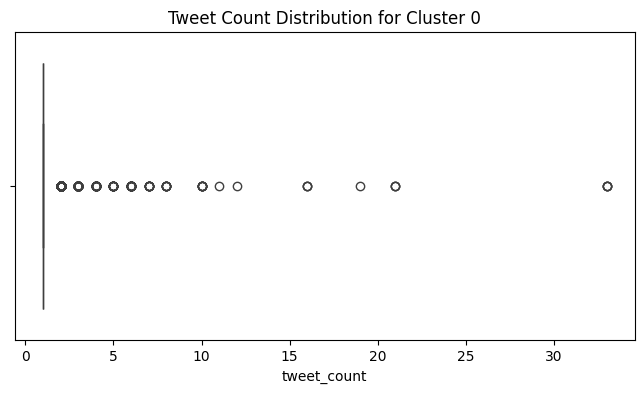

   - Total Users: 3,743
   - Users in this cluster are moderately active, sharing news and articles. Examples include user IDs such as `1012826112` and `1071456262`.
   - Most users have low activity, with only 1 or 2 tweets.

2. **Cluster 1 (Health and Mental Wellness):**

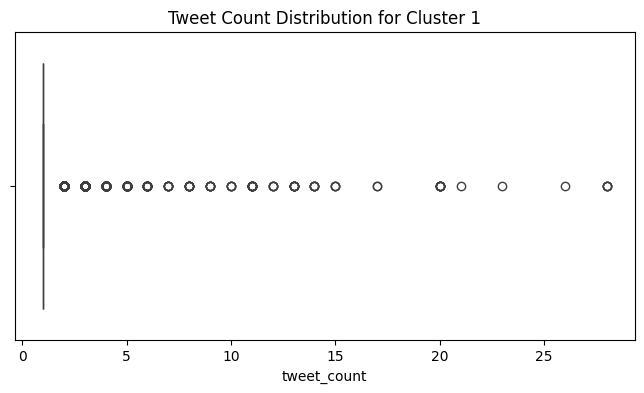

   - Total Users: 7,272
   - This cluster has a large and diverse audience focused on health-related discussions. Example user IDs include `1069318167` and `1076396056`.
   - Users generally have low activity, with most contributing a single tweet.

3. **Cluster 2 (Climate and Weather):**

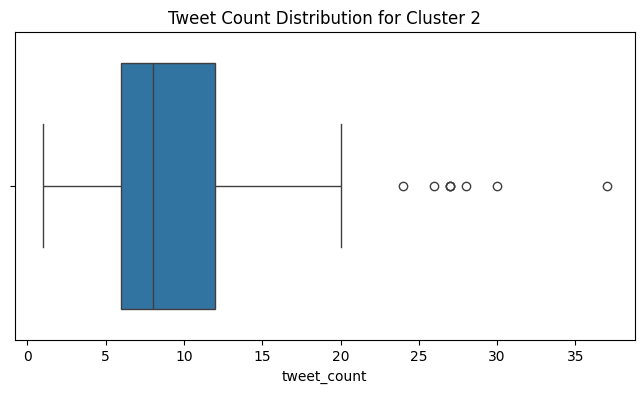

   - Total Users: 131
   - A small, niche group discussing weather and climate topics, with some highly active users. For instance, user `1004884654` has 14 tweets.
   - This indicates a focused but limited audience contributing extensively to the theme.

4. **Cluster 3 (General Conversations):**

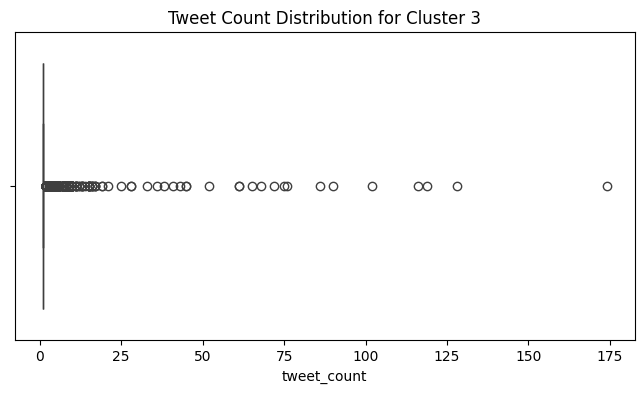

   - Total Users: 22,406
   - This is the largest cluster, representing general discussions. Example user IDs include `1078067202` and `1032847366`.
   - Users are mostly low-frequency contributors, reflecting a broad but unfocused user base.

5. **Cluster 4 (Voting and Social Topics):**

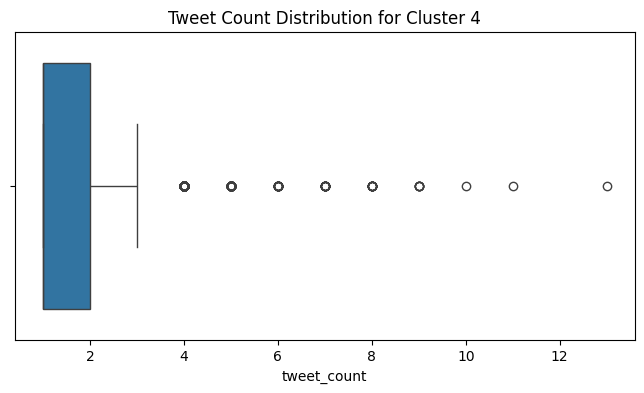

   - Total Users: 4,325
   - A moderately sized cluster focused on social movements and campaigns. Example users include `1009475584` and `1009876992`.
   - Activity levels vary, with some users contributing multiple tweets on these topics.

6. **Cluster 5 (Politics and Governance):**

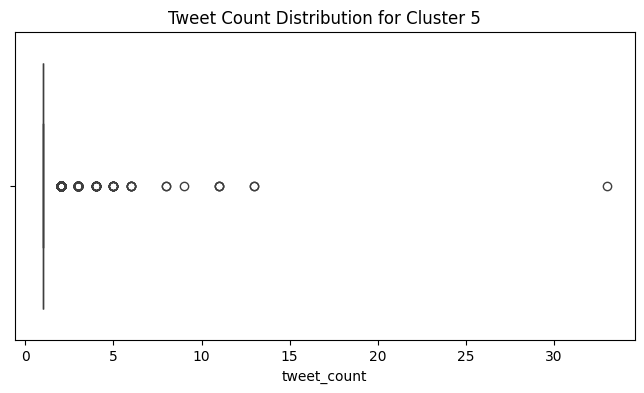

   - Total Users: 3,602
   - This cluster consists of politically active users. Examples include user IDs such as `1029742592` and `1063534594`.
   - Most users contribute only a single tweet, suggesting broad participation but limited depth of discussion.

7. **Cluster 6 (Scientific Research and Innovation):**

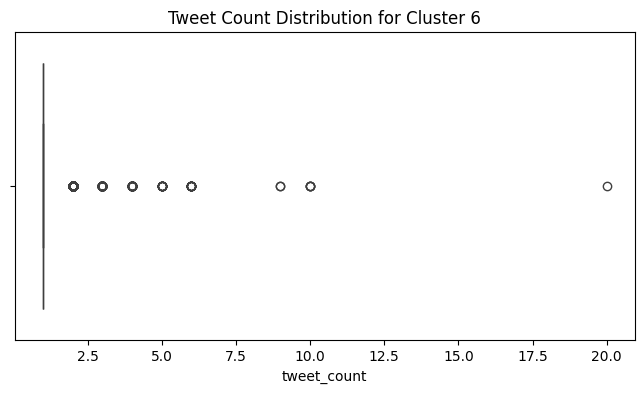

   - Total Users: 2,536
   - A focused group discussing scientific topics, with users like `1085071364` and `1018716167`.
   - Most users have low activity, but the high weights of terms like "science" suggest meaningful discussions.

8. **Cluster 7 (Business and Marketing):**

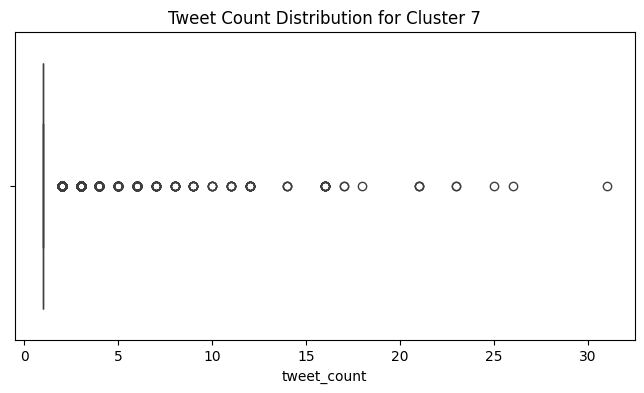

   - Total Users: 6,985
   - Users in this cluster focus on professional and entrepreneurial topics. Examples include user IDs such as `1039794189` and `1032159248`.
   - Activity levels are low for most users, with occasional active participants.

9. **Cluster 8 (Climate Activism):**

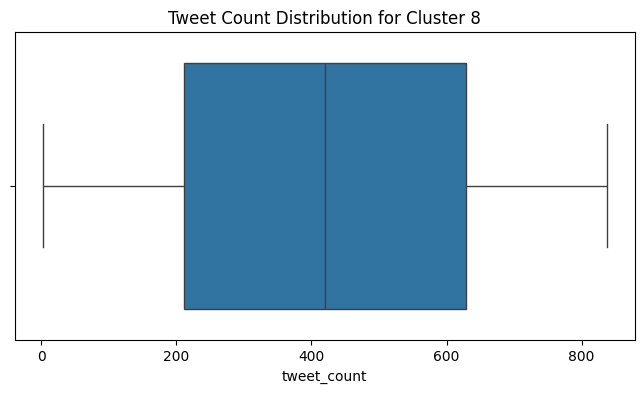

   - Total Users: 2
   - This cluster is highly specific, with just 2 users dominating the conversation. User `1010626427` is exceptionally active, with 837 tweets.
   - This indicates a concentrated discussion driven by a small group of influencers or advocates.




### Key Takeaways:

1. **Cluster Diversity:**
   - Clusters range from broad, general discussions (Cluster 3) to highly specific and niche topics (Cluster 8).

2. **Activity Patterns:**
   - Most clusters are dominated by low-activity users contributing single tweets, except for niche clusters like Cluster 8, where a few users drive the conversation.

3. **Thematic Focus:**
   - Clusters represent distinct thematic areas, such as news, politics, health, science, and climate activism. These can guide targeted analyses for specific themes or audiences.